# WeRateDogs

In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import tweepy
import requests
import json
import matplotlib.pyplot as plt
import os 
import re
import datetime
import seaborn as sns
from scipy import stats 

## Gathering

In [2]:
# Import the twitter-archive-enhanced csv file into a DataFrame
archive_df= pd.read_csv("twitter-archive-enhanced.csv")

In [3]:
# Check to see if the file was imported correctly
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
# Downloading and saving the image prediction data using Requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r=requests.get(url)

In [5]:
r

<Response [200]>

In [6]:
filename=url.split('/')[-1]
filename

'image-predictions.tsv'

In [7]:
if not os.path.isfile(filename):
    with open(filename, 'wb') as f:
        f.write(r.content)

In [8]:
# Import the image-predictions tsv file into a DataFrame
image_predictions_df= pd.read_csv('image-predictions.tsv',sep='\t')

In [9]:
# Check to see if the file was imported correctly
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [10]:
# Import the twitter-archive-enhanced csv file into a DataFrame
df_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
 # Check to see if the file was imported correctly       
api_df = pd.DataFrame(df_list)
api_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


## Assessing

### Visual assessment

In [11]:
# Display the archive table
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
# Display the image prediction table
image_predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [13]:
# Display the archive table
api_df

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256
5,20562,3261,891087950875897856
6,12041,2158,890971913173991426
7,56848,16716,890729181411237888
8,28226,4429,890609185150312448
9,32467,7711,890240255349198849


### Programmatic assessment:


In [14]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [17]:
#seeing duplicated columns
all_columns = pd.Series(list(archive_df) + list(image_predictions_df) + list(api_df))
all_columns[all_columns.duplicated()]

17    tweet_id
31    tweet_id
dtype: object

In [18]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [19]:
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
api_df.describe()

,favorite_count,retweet_count,tweet_id
count,2354.000000,2354.000000,2.354000e+03
mean,8080.968564,3164.797366,7.426978e+17
std,11814.771334,5284.770364,6.852812e+16
min,0.000000,0.000000,6.660209e+17
25%,1415.000000,624.500000,6.783975e+17
50%,3603.500000,1473.500000,7.194596e+17
75%,10122.250000,3652.000000,7.993058e+17
max,132810.000000,79515.000000,8.924206e+17


In [21]:
#the number of every dog breed
(archive_df.loc[:, 'doggo':"puppo"] != 'None') .sum()

doggo       97
floofer     10
pupper     257
puppo       30
dtype: int64

In [22]:
# Getting all the tweets where the value of both 'doggo' and 'pupper' is not none
nonunique_stage = archive_df[(archive_df['doggo'] != 'None') & (archive_df['pupper'] != 'None')]

# Extracting only those the columns of interest and investigate its head
nonunique_stage.iloc[:, -4:].head()

,doggo,floofer,pupper,puppo
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None


In [23]:
#detect all strange names less than 3 letters
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_df.iterrows():  
    if len(str(row['name'])) < 3 and row['name'][0].islower():
        print(row['name'])

a
a
an
a
my
a
a
a
an
a
a
a
a
a
a
an
a
a
a
by
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
an
a
a
a
a
a
a
a
a
a
a
a
a
a
an
a
an
a
a
an
a
a
a
a


In [24]:
#detect all strange names more than 3 letters
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_df.iterrows():  
    if len(str(row['name'])) > 3 and row['name'][0].islower():
        print(row['name'])

such
quite
quite
quite
incredibly
very
very
just
very
actually
just
getting
very
this
unacceptable
infuriating
very
getting
just
actually
officially
life
light
just
space
quite


#### Quality
##### Archive dataframe 
- all timestamps are object type (consistency issues)
- all tweet ids are integers
- Nulls represented as None in the (name,doggo,floffer,pupper,puppo) columns
- there are some records that has 2 types from (doggo,floffer,pupper,puppo)
- There were retweets and replies
- Erroneous names like the letters 'a','an', other names as shown in assesment
- Missing values in expanded urls
- incorrect values in ratings numerator (max is 1776),denominator(max is 170) 

##### image predictions dataframe
- non discriptive columns
- missing records (2057 instead of 2356)shows that there were retweets and replies needed to be excluded


#### Tidiness
##### Archive dataframe 
- values are column names (doggo,floffer,pupper,puppo)

##### image predictions dataframe
- values are column names (p1,p2,p3)

##### API dataframe
- it is not an observational unit so we do not need a separate table 


## Clean

In [25]:
#copying all data frames
archive_clean = archive_df.copy()
image_clean = image_predictions_df.copy()
api_clean = api_df.copy()

### Missing Data and exclusion the retweets

#### there are retweets needs to be excluded from archive , image predictions data frames
#### missing values in expanded urls

##### Define
Drop the records that have no images from both the archive and api datafames using the image prediction dataframe. As a result the 3 dataframes will have the same row count of the image prediction dataframe which is"2075"

Drop the replies and retweets,the count will be 1971

Drop the retweets and replies from the image prediction,the count will be 1971

Drop the retweered and in reply columns

##### Code

In [26]:
# creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(image_clean.tweet_id.unique())

# confirming that all the tweets with images exist in the archive dataset
len(tweets_with_image) == archive_clean.tweet_id.isin(tweets_with_image).sum()

# Cleaning in action ;)
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_image)]

In [27]:
# Throwback to the archive dataset to extract the tweets that include data in the retweet_status_id.
retweet_entries = archive_clean.retweeted_status_id.notnull()
archive_clean[retweet_entries].shape[0]

# Dropping the retweets from the archive data set
archive_clean = archive_clean[~retweet_entries]

# Throwback to the archive dataset to extract the tweets that include data in the in_reply_to_status_id
in_reply_to_entries = archive_clean.in_reply_to_status_id.notnull()
archive_clean[in_reply_to_entries].shape[0]

# Dropping the retweets from the archive data set
archive_clean = archive_clean[~in_reply_to_entries]

#Drop the retweered and in reply columns
archive_clean=archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id', 'retweeted_status_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis = 1) 



In [28]:
#Now we check the image_prediction table for extra tweet ids not in the archive table
np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id)))

# Dropping the retweets and replies ids from the image prediction dataframe
image_clean=image_clean[~np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id)))]

##### Test

In [29]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
dtypes: int64(3), object(9)
memory usage: 200.2+ KB


In [30]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1971 non-null int64
jpg_url     1971 non-null object
img_num     1971 non-null int64
p1          1971 non-null object
p1_conf     1971 non-null float64
p1_dog      1971 non-null bool
p2          1971 non-null object
p2_conf     1971 non-null float64
p2_dog      1971 non-null bool
p3          1971 non-null object
p3_conf     1971 non-null float64
p3_dog      1971 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


In [31]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [32]:
archive_clean[archive_clean['expanded_urls'].isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Tidiness

##### Archive dataframe 
- values are column names (doggo,floffer,pupper,puppo)


##### Define
combine in one column called Dog_breed 

##### code

In [33]:
#replacing none with empty string
archive_clean.iloc[:, -4:  ] = archive_clean.iloc[:, -4:  ].replace('None','')

In [34]:
#combine in one column called Dog_breed
archive_clean['Dog_breed'] = archive_clean['doggo'] + archive_clean['floofer']+archive_clean['pupper']+archive_clean['puppo']

In [35]:
#drop unneeded columns
archive_clean=archive_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1)

##### Test

In [36]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Dog_breed
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


#### Tidiness
##### image predictions dataframe
- values are column names (p1,p2,p3)
#### Quality 
- columns are not descriptive


##### Define 
rename the columns 
reshaping the data frame

##### Code

In [37]:
# Renaming the dataset columns
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_clean.columns = cols

# Reshaping the dataframe
image_clean= pd.wide_to_long(image_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

##### Test

In [38]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
tweet_id            5913 non-null int64
jpg_url             5913 non-null object
img_num             5913 non-null int64
prediction_level    5913 non-null int64
prediction          5913 non-null object
confidence          5913 non-null float64
breed               5913 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 283.0+ KB


In [39]:
image_clean.head()

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True


#### Tidiness

##### API dataframe
- it is not an observational unit so we do not need a separate table 


##### Define 
merge to the archive dateframe

##### Code

In [40]:
archive_clean = pd.merge(archive_clean, api_clean,
                            on=['tweet_id'], how='left')

##### Test

In [41]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Dog_breed,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,39467,8853
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,33819,6514
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,25461,4328
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,42908,8964
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,41048,9774


In [42]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
Dog_breed             1971 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
dtypes: int64(5), object(6)
memory usage: 184.8+ KB


### Quality
- all timestamps are object type (consistency issues)
- all tweet ids are integers


##### Define
convert timestamps to datetime type
convert all tweet ids to string type

##### Code

In [43]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

In [44]:
image_clean.tweet_id = image_clean.tweet_id.astype(str)

In [45]:
archive_clean.timestamp= pd.to_datetime(archive_clean.timestamp)

##### Test

In [46]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
tweet_id            5913 non-null object
jpg_url             5913 non-null object
img_num             5913 non-null int64
prediction_level    5913 non-null int64
prediction          5913 non-null object
confidence          5913 non-null float64
breed               5913 non-null bool
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 283.0+ KB


In [47]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
Dog_breed             1971 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 184.8+ KB


#### Quality
##### Archive dataframe 
- Nulls represented as None in the (name,doggo,floffer,pupper,puppo) columns in (Dogs_breed now)

##### Define 
convert none values to Nans

##### Code

In [48]:
archive_clean= archive_clean.replace(r'^\s*$', np.NaN, regex=True)


##### Test

In [49]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Dog_breed,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,39467,8853
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,33819,6514
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,25461,4328
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,42908,8964
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,41048,9774


In [50]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
Dog_breed             303 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 184.8+ KB


#### Quality
##### Archive dataframe 
- there are some records that has 2 types from (doggo,floffer,pupper,puppo)

##### Define
detect them in the new column (Dog_breed)and replace them with readable names

##### Code

In [51]:
 archive_clean['Dog_breed'].value_counts(dropna = False) 

NaN             1668
pupper           201
doggo             63
puppo             22
doggopupper        8
floofer            7
doggopuppo         1
doggofloofer       1
Name: Dog_breed, dtype: int64

In [52]:
archive_clean.Dog_breed = archive_clean.Dog_breed.replace('doggopupper', 'doggo-pupper')

In [53]:
archive_clean.Dog_breed = archive_clean.Dog_breed.replace('doggofloofer', 'doggo-floofer')

In [54]:
archive_clean.Dog_breed = archive_clean.Dog_breed.replace('doggopuppo', 'doggo-puppo')

##### Test

In [55]:
archive_clean['Dog_breed'].value_counts(dropna = False) 

NaN              1668
pupper            201
doggo              63
puppo              22
doggo-pupper        8
floofer             7
doggo-floofer       1
doggo-puppo         1
Name: Dog_breed, dtype: int64

#### Quality
##### Archive dataframe 
- Erroneous names like the letters 'a','an', other names as shown in assesment

##### Define
extract the correct name if exist

##### Code

In [56]:
#pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
#for index, row in archive_clean.iterrows():  
    #if row['name'][0].islower() or row['name'] == 'None':
        #try:
            #c_name = re.findall(pattern_2, row['text'])[0]
            #archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace(row['name'], c_name)

        #except IndexError:
            #archive_clean.loc[index,'name'] = np.nan

            


In [57]:
for index, row in archive_clean.iterrows():  
        if (len(str(row['name'])) >3 and row['name'][0].islower())or(len(str(row['name'])) <3 and row['name'][0].islower()):
            try:
                c_name = re.findall(pattern_2, row['text'])[0]
                archive_clean.loc[index,'name']=archive_clean.loc[index,'name'] =c_name
            except IndexError:
                archive_clean.loc[index,'name'] = np.nan


##### Test

In [58]:
archive_clean.name.value_counts(dropna = False)

None         524
NaN           62
Charlie       11
Lucy          10
Oliver        10
Cooper        10
Penny          9
Tucker         9
Sadie          8
Winston        8
Toby           7
the            7
Daisy          7
Lola           7
Bo             6
Stanley        6
Koda           6
Jax            6
Bella          6
Buddy          5
Milo           5
Oscar          5
Dave           5
Scout          5
Leo            5
Bailey         5
Chester        5
Louis          5
Rusty          5
Zoey           4
            ... 
Bertson        1
Rooney         1
Chuk           1
Augie          1
Enchilada      1
Eevee          1
Ike            1
Marlee         1
Sprout         1
Monster        1
Hazel          1
Dallas         1
Nugget         1
Huck           1
Lacy           1
Duchess        1
DayZ           1
Thor           1
Striker        1
Kendall        1
Donny          1
Meyer          1
Rhino          1
Rocco          1
Zara           1
Butter         1
Mike           1
Sandra        

In [59]:
#now there are not names that lower and less than 3 ketters
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_clean.iterrows():  
    if len(str(row['name'])) >3 and row['name'][0].islower():
        print(row['name'])

In [60]:
#now there are not names that lower and more than 3 ketters
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_clean.iterrows():  
    if len(str(row['name'])) <3 and row['name'][0].islower():
        print(row['name'])

#### Quality
##### Archive dataframe 
- incorrect values in ratings numerator (max is 1776),denominator(max is 170) 

##### Define 
- detect the strange values 
- Drop high values as they are outliers
- solve some records  after viewing their texts
- solve some records progmitcally (that contain more than one dog)
- solve records that containing fractions

##### Code

In [61]:
 archive_clean['rating_denominator'].value_counts(dropna = False) 

10     1954
50        3
80        2
11        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [62]:
 archive_clean['rating_numerator'].value_counts(dropna = False) 

12      446
10      417
11      392
13      253
9       150
8        95
7        52
5        33
14       33
6        32
3        19
4        16
2         9
1         5
1776      1
24        1
26        1
420       1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

In [63]:
#slicing the strange records denominator to see the text and examine it
Great_than10 = archive_clean.loc[(archive_clean["rating_denominator"]>10),['text']]  
Great_than10

,text
320,The floofs have been released I repeat the flo...
658,Why does this never happen at my front door......
794,"After so many requests, this is Bretagne. She ..."
842,Say hello to this unbelievably well behaved sq...
884,Happy 4/20 from the squad! 13/10 for all https...
918,This is Bluebert. He just saw that both #Final...
939,Happy Saturday here's 9 puppers on a bench. 99...
963,Here's a brigade of puppers. All look very pre...
981,"From left to right:\nCletus, Jerome, Alejandro..."
1045,Here is a whole flock of puppers. 60/50 I'll ...


In [64]:
#solve some records progmitcally (that contain more than one dog)
more_dogs=archive_clean.loc[archive_clean['rating_numerator'] >= 40]
dogs_count = more_dogs.rating_denominator/10
archive_clean.loc[archive_clean.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [archive_clean.rating_numerator[archive_clean.rating_numerator >= 40]/dogs_count , 10]


In [65]:
archive_clean[archive_clean['rating_denominator']!=10].rating_denominator.value_counts()

11    2
7     1
20    1
2     1
Name: rating_denominator, dtype: int64

In [66]:
archive_clean[archive_clean['rating_numerator']>15].rating_numerator.value_counts()

420.0     1
26.0      1
1776.0    1
27.0      1
75.0      1
24.0      1
Name: rating_numerator, dtype: int64

In [67]:
#solve records that containing fractions
pattern=re.compile('(\d+\.?\d?\d?)\/\d{1,3}')
for index, row in archive_clean.iterrows():  
    if row['rating_numerator']> 15:
            correct_numerator = re.findall(pattern, row['text'])[0]
            archive_clean.loc[index,'rating_numerator'] = archive_clean.loc[index,'rating_numerator']=correct_numerator

In [68]:
archive_clean.rating_numerator = archive_clean.rating_numerator.astype(float)

In [69]:
archive_clean[archive_clean['rating_numerator']>15].rating_numerator.value_counts()

420.0     1
1776.0    1
24.0      1
Name: rating_numerator, dtype: int64

In [70]:
#slicing the remaining records numerators to see the text and examine it
Great_than15 = archive_clean.loc[(archive_clean["rating_numerator"]>15),['text']]  
Great_than15

,text
382,Meet Sam. She smiles 24/7 &amp; secretly aspir...
722,This is Atticus. He's quite simply America af....
1696,After so many requests... here you go.\n\nGood...


In [71]:
#Drop high values as they are outliers
index_1= archive_clean[((archive_clean.rating_numerator == 1776))].index
archive_clean=archive_clean.drop(index_1)
index_2= archive_clean[((archive_clean.rating_numerator == 420))].index
archive_clean=archive_clean.drop(index_2)

In [72]:
archive_clean[archive_clean['rating_numerator']>15].rating_numerator.value_counts()

24.0    1
Name: rating_numerator, dtype: int64

In [73]:
#solve the problem of (24/7)
archive_clean.rating_numerator= archive_clean.rating_numerator.replace(24,11)
archive_clean.rating_denominator= archive_clean.rating_denominator.replace(7,10)

In [74]:
#slicing the remaining records denominator to see the text and examine it
notequal_10 = archive_clean.loc[(archive_clean["rating_denominator"]!=10),['text']]  
notequal_10

,text
794,"After so many requests, this is Bretagne. She ..."
884,Happy 4/20 from the squad! 13/10 for all https...
1313,This is Darrel. He just robbed a 7/11 and is i...
1950,This is an Albanian 3 1/2 legged Episcopalian...


In [75]:
#solve the remainig records (adjust denominator)
archive_clean.rating_denominator= archive_clean.rating_denominator.replace(11,10)
archive_clean.rating_denominator= archive_clean.rating_denominator.replace(20,10)
archive_clean.rating_denominator= archive_clean.rating_denominator.replace(2,10)

In [76]:
#solve the remainig records (adjust numerator)
archive_clean.loc[794,'rating_numerator'] = 14
archive_clean.loc[884,'rating_numerator'] = 13
archive_clean.loc[1313,'rating_numerator'] = 10
archive_clean.loc[1950,'rating_numerator'] = 9


##### Test

In [77]:
 archive_clean['rating_denominator'].value_counts(dropna = False) 

10    1969
Name: rating_denominator, dtype: int64

In [78]:
 archive_clean['rating_numerator'].value_counts(dropna = False) 

12.00    450
10.00    420
11.00    398
13.00    254
9.00     151
8.00      95
7.00      51
14.00     34
5.00      33
6.00      32
3.00      19
4.00      15
2.00       9
1.00       4
11.27      1
0.00       1
11.26      1
9.75       1
Name: rating_numerator, dtype: int64

## Storing Data frames after cleaning it 

In [79]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)

In [80]:
image_clean.to_csv('image_predictions_tidy.csv', index=False)

## Analysis AND Visualization 

In [81]:
# loading files into dataframe to work with
twitter_df=pd.read_csv('twitter_archive_master.csv')
image_df=pd.read_csv('image_predictions_tidy.csv')

In [82]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 11 columns):
tweet_id              1969 non-null int64
timestamp             1969 non-null object
source                1969 non-null object
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1907 non-null object
Dog_breed             303 non-null object
favorite_count        1969 non-null int64
retweet_count         1969 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 169.3+ KB


In [83]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
tweet_id            5913 non-null int64
jpg_url             5913 non-null object
img_num             5913 non-null int64
prediction_level    5913 non-null int64
prediction          5913 non-null object
confidence          5913 non-null float64
breed               5913 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 283.0+ KB


In [84]:
#as their datatypes changes we will convert them to original ones 
twitter_df.tweet_id =twitter_df.tweet_id.astype('str')
twitter_df.Dog_breed =twitter_df.Dog_breed.astype('category')
twitter_df['timestamp']=pd.to_datetime(twitter_df.timestamp)
image_df.tweet_id=image_df.tweet_id.astype('str')
image_df.prediction_level=image_df.prediction_level.astype('category')

In [85]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 11 columns):
tweet_id              1969 non-null object
timestamp             1969 non-null datetime64[ns]
source                1969 non-null object
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1907 non-null object
Dog_breed             303 non-null category
favorite_count        1969 non-null int64
retweet_count         1969 non-null int64
dtypes: category(1), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 156.2+ KB


In [86]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
tweet_id            5913 non-null object
jpg_url             5913 non-null object
img_num             5913 non-null int64
prediction_level    5913 non-null category
prediction          5913 non-null object
confidence          5913 non-null float64
breed               5913 non-null bool
dtypes: bool(1), category(1), float64(1), int64(1), object(3)
memory usage: 242.7+ KB


In [87]:
sns.set_context(context='notebook')

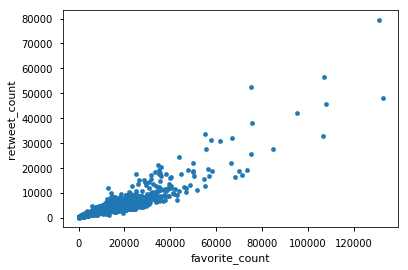

In [88]:
twitter_df.plot(x='favorite_count', y='retweet_count', kind='scatter');

In [89]:
twitter_timeseries=twitter_df.copy()
twitter_timeseries=twitter_timeseries.set_index('timestamp')
twitter_timeseries.sort_index()
master_timeseries=twitter_timeseries.reset_index().merge(image_df[image_df.prediction_level==1],on='tweet_id',how='left').set_index(twitter_timeseries.index)

([<matplotlib.axis.XTick at 0x7fb88698cf98>,
 <a list of 6 Text xticklabel objects>)

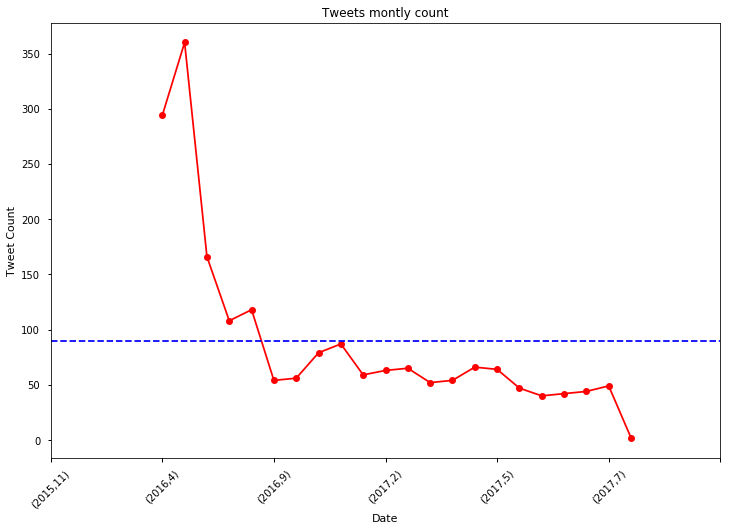

In [90]:
sns.set_context('notebook')
master_timeseries.groupby([(master_timeseries.index.year),(master_timeseries.index.month)]).tweet_id.count().plot(style='-ro', figsize=(12,8))
mn=np.mean(master_timeseries.groupby([(master_timeseries.index.year),(master_timeseries.index.month)]).count()['tweet_id'])
plt.axhline(y=mn, color='b', linestyle='--', label='Out of rating')
plt.xlabel('Date');plt.ylabel('Tweet Count');
plt.title('Tweets montly count')
locs,labels=plt.xticks()
plt.xticks(locs,('(2015,11)','(2016,4)','(2016,9)','(2017,2)','(2017,5)','(2017,7)'),rotation=45)

In [91]:
master_timeseries.groupby(['breed']).retweet_count.describe()

,count,mean,std,min,25%,50%,75%,max
breed,,,,,,,,
False,506.0,2727.877470,4453.929715,34.0,591.5,1139.5,2885.0,37911.0
True,1463.0,2802.971975,4783.379234,16.0,656.0,1451.0,3265.5,79515.0


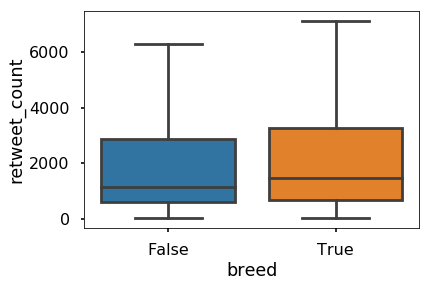

In [92]:
sns.set_context('poster')
ax=sns.boxplot(x='breed',y='retweet_count',data=master_timeseries,showfliers=False)

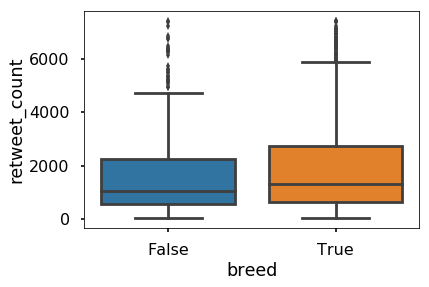

In [93]:
ax=sns.boxplot(x='breed',y='retweet_count',data=master_timeseries[master_timeseries.retweet_count<7500])

In [94]:
master_timeseries.groupby(['breed']).favorite_count.describe()

,count,mean,std,min,25%,50%,75%,max
breed,,,,,,,,
False,506.0,7849.369565,11082.016971,108.0,1508.5,3223.5,9610.5,75639.0
True,1463.0,9332.433356,12641.104102,81.0,2234.0,4531.0,11836.0,132810.0


[None, None, None, None]

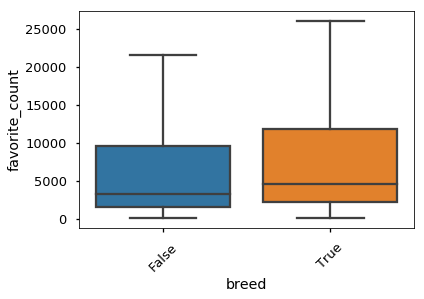

In [95]:
sns.set_context('talk')
ax=sns.boxplot(x='breed',y='favorite_count',data=master_timeseries,showfliers=False)
plt.setp(ax.get_xticklabels(),rotation=45)


([<matplotlib.axis.XTick at 0x7fb8867abb38>,
 <a list of 6 Text xticklabel objects>)

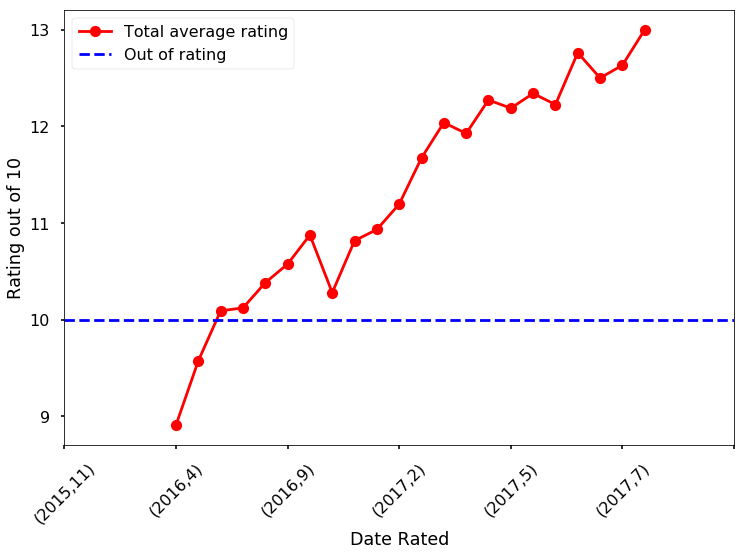

In [96]:
sns.set_context('poster')
twitter_timeseries=twitter_df.copy()
twitter_timeseries.index=twitter_timeseries['timestamp']
twitter_timeseries.drop(columns=['timestamp'],inplace=True)
twitter_timeseries.sort_index(inplace=True)
twitter_timeseries.groupby([(twitter_timeseries.index.year),(twitter_timeseries.index.month)]).rating_numerator.mean().plot(style='-ro', figsize=(12,8),label='Total average rating')
plt.axhline(y=10.0, color='b', linestyle='--', label='Out of rating')
plt.xlabel('Date Rated');plt.ylabel('Rating out of 10');
plt.legend();
locs,labels=plt.xticks()
plt.xticks(locs,('(2015,11)','(2016,4)','(2016,9)','(2017,2)','(2017,5)','(2017,7)'),rotation=45)



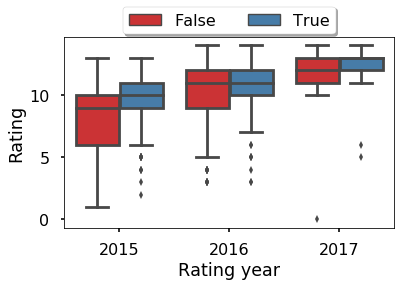

In [97]:
sns.set_context('poster')
plt.subplots(figsize=(6,4))
sns.boxplot(master_timeseries.index.year,master_timeseries.rating_numerator,hue=master_timeseries.breed,palette='Set1')
plt.legend(loc=8)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.2),ncol=3,fancybox=True,shadow=True)
plt.xlabel('Rating year');plt.ylabel('Rating');
plt.tight_layout()


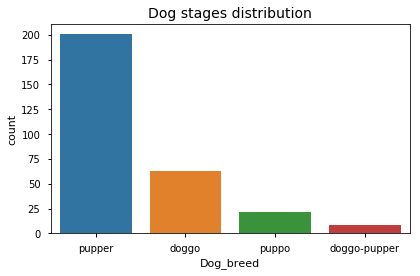

In [98]:
sns.set_context('notebook')
ordered_stages=twitter_df['Dog_breed' ].value_counts().head(4).index
sns.countplot(data=twitter_df,x='Dog_breed',order=ordered_stages,orient='h' )
plt.title('Dog stages distribution',fontsize=14);
plt.tight_layout()


In [99]:
avg_retweet_count_dog_breed=twitter_df.groupby('Dog_breed').retweet_count.mean()
avg_retweet_count_dog_breed.index

CategoricalIndex(['doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo',
                  'floofer', 'pupper', 'puppo'],
                 categories=['doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo', 'floofer', 'pupper', 'puppo'], ordered=False, name='Dog_breed', dtype='category')

In [100]:
avg_retweet_count_dog_breed

Dog_breed
doggo             7125.698413
doggo-floofer     3433.000000
doggo-pupper      4397.250000
doggo-puppo      19196.000000
floofer           4968.714286
pupper            2382.502488
puppo             6473.954545
Name: retweet_count, dtype: float64

In [101]:
avg_favorite_count_dog_breed=twitter_df.groupby('Dog_breed').favorite_count.mean()


In [102]:
avg_favorite_count_dog_breed

Dog_breed
doggo            19356.380952
doggo-floofer    17169.000000
doggo-pupper     13219.875000
doggo-puppo      47844.000000
floofer          13206.000000
pupper            7250.527363
puppo            21582.090909
Name: favorite_count, dtype: float64

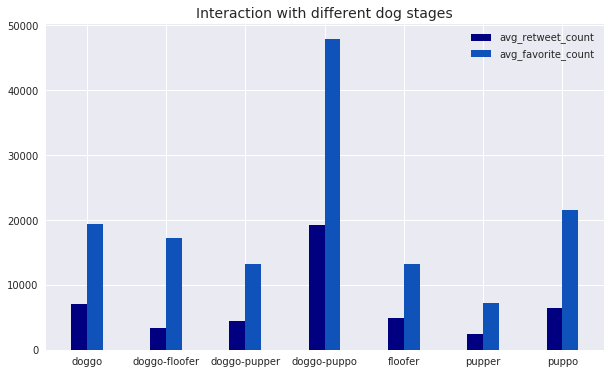

In [103]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
width=0.2
ind=np.arange(len(avg_favorite_count_dog_breed))
locations=ind+width/2
labels=avg_favorite_count_dog_breed.index
plt.bar(ind,avg_retweet_count_dog_breed,width,color='#000080',label='avg_retweet_count')
plt.bar(ind+width,avg_favorite_count_dog_breed,width,color='#0F52BA',label='avg_favorite_count')
plt.xticks(locations,labels)
plt.legend();
plt.title('Interaction with different dog stages',fontsize=14);



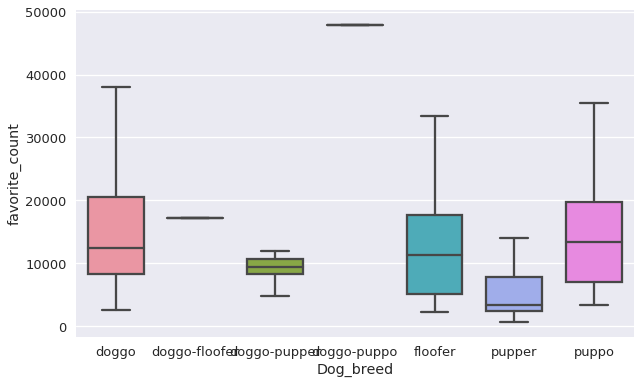

In [104]:
sns.set_context('talk')
ax=sns.boxplot(x='Dog_breed',y='favorite_count',showfliers=False,width=0.7,data=master_timeseries)
sns.set(rc={'figure.figsize':(26,16)})




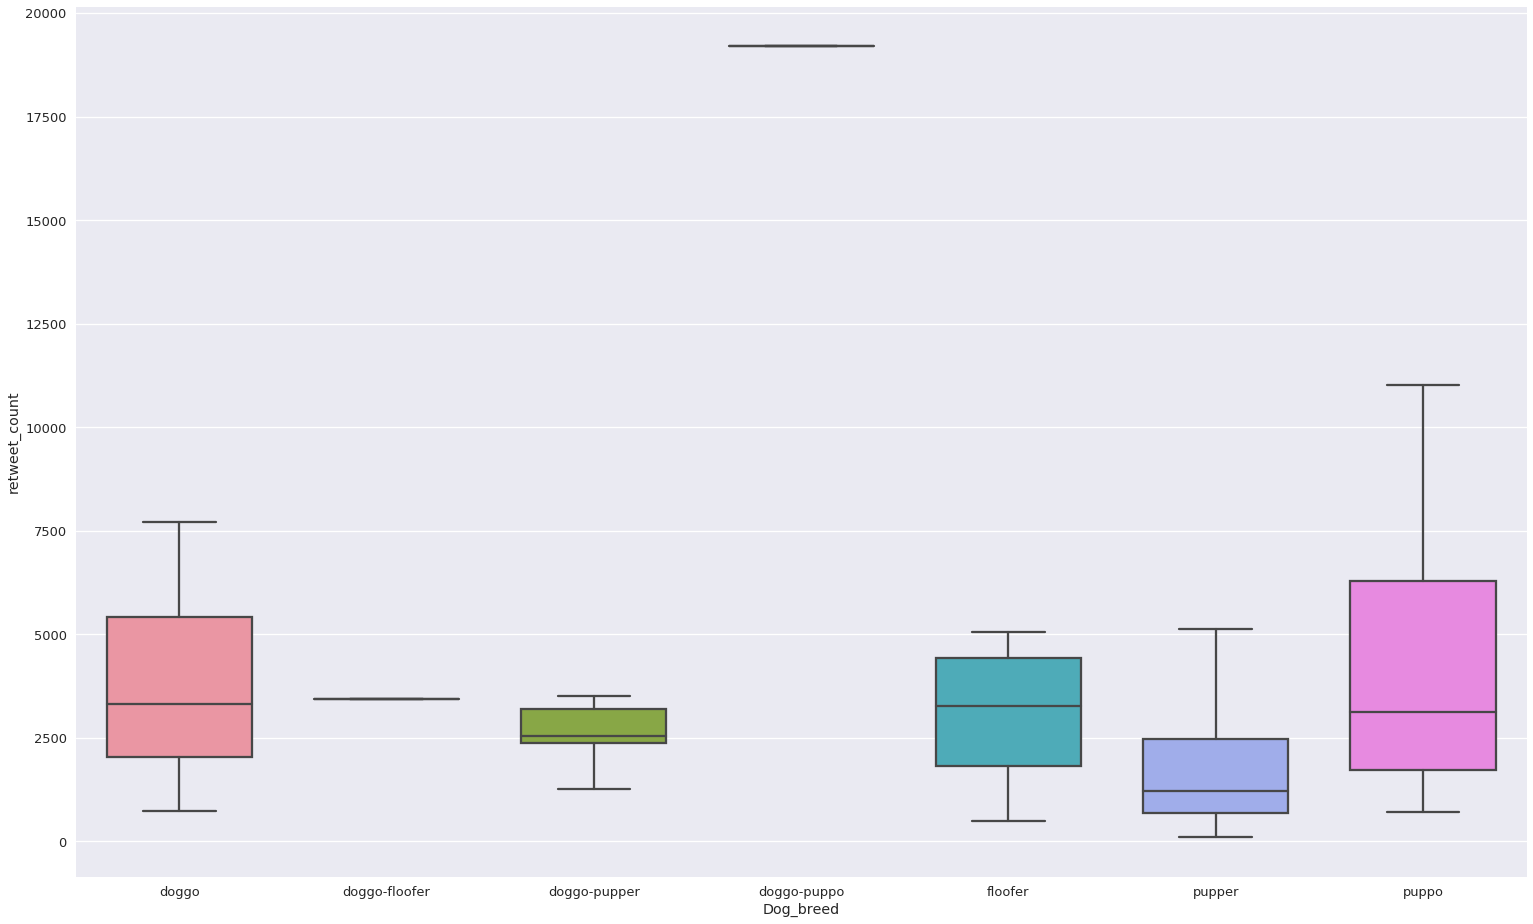

In [105]:
sns.set_context('talk')
ax=sns.boxplot(x='Dog_breed',y='retweet_count',showfliers=False,width=0.7,data=master_timeseries)
sns.set(rc={'figure.figsize':(26,16)})

